# Sine-Gaussian Baseline Flow training

- Normalizing flow with no data summary

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


In [3]:
def sine_gaussian(t, f_0, tau, shift=0):
    t_shift = t - shift
    data = torch.exp(-1*t_shift*t_shift / tau / tau) * torch.sin(2*torch.pi*f_0 * t_shift)
    return data

def sine_gaussian_bilby(t, f_0, tau, shift=0):
    t_shift = t - shift
    data = np.exp(-1*t_shift*t_shift / tau / tau) * np.sin(2*np.pi*f_0 * t_shift)
    return data

## Plot

Text(0.5, 1.0, 'Time Shifted Signal for f_0 = 0.7, tau = 3.0')

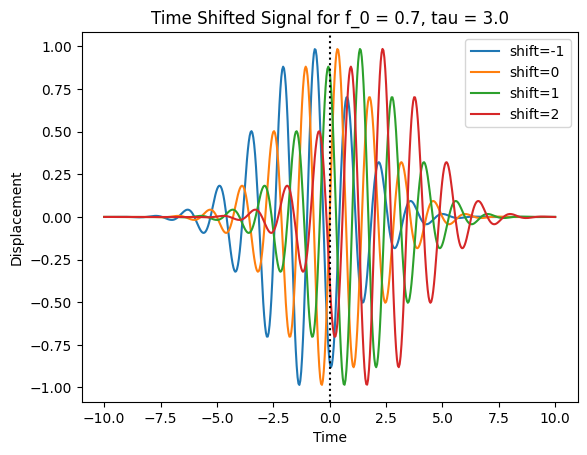

In [4]:
_f_0 = torch.tensor(0.7)
tau = torch.tensor(3)

t_vals = torch.linspace(-10, 10, 500)
for shift in [-1, 0, 1, 2]:
    x_vals = sine_gaussian(t_vals, f_0=_f_0, tau=tau, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{shift=}")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()
plt.title(f"Time Shifted Signal for f_0 = {_f_0:.1f}, tau = {tau:.1f}")

In [5]:
injection_parameters = dict(f_0=_f_0, tau=tau, shift=4)
print(injection_parameters)

{'f_0': tensor(0.7000), 'tau': tensor(3), 'shift': 4}


In [6]:
num_points = 500
t_vals = np.linspace(-10, 10, num_points)

In [7]:
sigma = 0.4

In [8]:
data = sine_gaussian_bilby(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0.5, 1.0, 'Data and Signal for Sine-Gaussian')

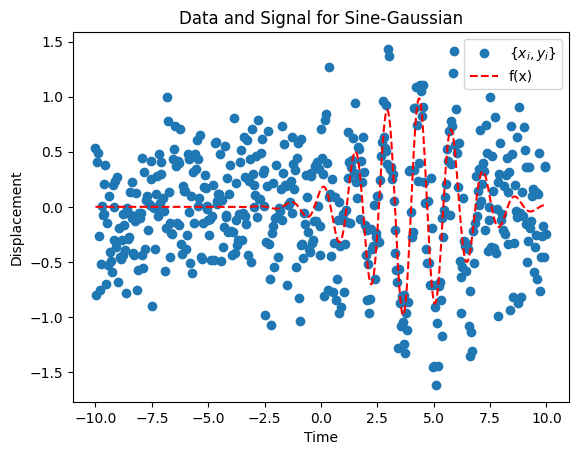

In [9]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, sine_gaussian(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.title('Data and Signal for Sine-Gaussian')

In [10]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [11]:
priors = dict()

priors['f_0'] = Uniform(0.1, 1, name='f_0', latex_label='$f_0$')
priors['tau'] = Uniform(1, 4, name='tau', latex_label='$\\tau$')
priors['shift'] = Uniform(-2, 2, name='shift', latex_label='$\Delta\;t$')

In [12]:
from IPython.display import clear_output
from time import sleep

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [13]:
def get_data(f_0=None, tau=None, shift=None, num_points=1):
    """Sample omega, tau, shift and return a batch of data with noise"""
    f_0 = priors['f_0'].sample() if f_0 is None else f_0
    f_0 = torch.tensor(f_0).to(dtype=torch.float32)
    tau = priors['tau'].sample() if tau is None else tau
    tau = torch.tensor(tau).to(dtype=torch.float32)
    shift = priors['shift'].sample() if shift is None else shift
    shift = torch.tensor(shift).to(dtype=torch.float32)
    
    t_vals = torch.linspace(-1, 10, num_points).to(dtype=torch.float32) #
    
    y = sine_gaussian(t_vals, f_0=f_0, tau=tau, shift=shift)
    y += sigma * torch.randn(size=y.size()).to(dtype=torch.float32)
    
    return t_vals, y, f_0, tau, shift

# Add augmentation

In [14]:
num_simulations = 100000
num_repeats = 10

In [15]:
%%time

theta_unshifted_vals = []
theta_shifted_vals = []
data_unshifted_vals = []
data_shifted_vals = []

for ii in range(num_simulations):
    # generated data with a fixed shift
    t_vals, y_unshifted, f_0, tau, shift = get_data(num_points=num_points, shift=1)
    # create repeats
    theta_unshifted = torch.tensor([f_0, tau, shift]).repeat(num_repeats, 1)
    theta_unshifted_vals.append(theta_unshifted)
    data_unshifted_vals.append(y_unshifted.repeat(num_repeats, 1))
    # generate shifted data
    theta_shifted = []
    data_shifted = []
    for _ in range(num_repeats):
        t_val, y_shifted, _omega, tau, shift = get_data(
            f_0=f_0, tau=tau,  # omega and tau same as above
            shift=None,
            num_points=num_points
        )
        theta_shifted.append(torch.tensor([f_0, tau, shift]))
        data_shifted.append(y_shifted)
    theta_shifted_vals.append(torch.stack(theta_shifted))
    data_shifted_vals.append(torch.stack(data_shifted))

/tmp/ipykernel_2289609/71512313.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_0 = torch.tensor(f_0).to(dtype=torch.float32)
/tmp/ipykernel_2289609/71512313.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau).to(dtype=torch.float32)


CPU times: user 1min 49s, sys: 2.18 s, total: 1min 52s
Wall time: 1min 52s


In [16]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # return shifted and unshifted theta and data
        return (
            theta_shifted_vals[idx].to(dtype=torch.float32, device=device),
            theta_unshifted_vals[idx].to(dtype=torch.float32, device=device),
            data_shifted_vals[idx].to(dtype=torch.float32, device=device),
            data_unshifted_vals[idx].to(dtype=torch.float32, device=device)
        )

In [17]:
dataset = DataGenerator()

In [18]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [19]:
TRAIN_BATCH_SIZE = 1000
VAL_BATCH_SIZE = 1000

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

# No Data Embedding provided

In [20]:
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

In [21]:
num_transforms = 5
num_blocks = 4
hidden_features = 30

context_features = num_points

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.1,
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device=device)

In [22]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  414020


# Train/Validate

In [23]:
num_augmentations = 10

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()

            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 5 == 0:
            last_loss = running_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [24]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=1e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [25]:
# writer = SummaryWriter("sg-flow-baseline.neurips", comment="With LR=1e-3", flush_secs=5)
# epoch_number = 0

In [26]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 100

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     flow.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer)

#     # no gradient tracking, for validation
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)

#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
#     for param_group in optimizer.param_groups:
#         print("Current LR = {:.3e}".format(param_group['lr']))
#     epoch_number += 1
#     try:
#         scheduler.step(avg_val_loss)
#     except TypeError:
#         scheduler.step()

In [27]:
# PATH = './sg-baseline-neurips.pth'
# torch.save(flow.state_dict(), PATH)

In [28]:
PATH = './sg-baseline-neurips.pth'
flow.load_state_dict(torch.load(PATH, map_location=device))
flow.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=30, bias=True)
          (context_layer): Linear(in_features=500, out_features=30, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (context_layer): Linear(in_features=500, out_features=30, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=30, out_features=30, bias=True)
                (1): MaskedLinear(in_features=30, out_features=30, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MaskedResidualBlock(
              (context_layer): Linear(in_features=500, out_features=30, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=30, out_features=30, bias=True)
  

In [29]:
from torchprofile import profile_macs

In [30]:
data = torch.randn(1000, num_points).to(device)
theta = torch.randn(1000, 2).to(device)
num_macs_embed = profile_macs(flow._embedding_net, args=(data,))
embedded_data = flow._embedding_net(data)

In [31]:
num_macs_forward = profile_macs(flow._transform, args=(theta, embedded_data))
print("#MACs: {:.2e}".format(num_macs_forward+num_macs_embed))

#MACs: 4.12e+08


/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::new_zeros". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::softplus". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::log". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::index_select". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


# Check on test data

In [32]:
import pandas as pd
import corner

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys({'f_0', 'tau'})
    injections['f_0'] = float(truth.numpy()[0])
    injections['tau'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'f_0', 'tau'})
    samples_numpy = samples.numpy()
    posterior['f_0'] = samples_numpy.T[0].flatten()
    posterior['tau'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)

    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [33]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["f_0", "tau",],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

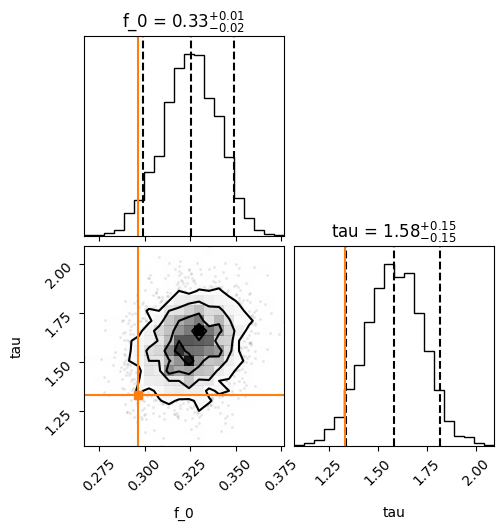

In [34]:
for idx, (_, theta_test, data_test, data_orig) in enumerate(test_data_loader):
    if idx % 1000 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 500)))
    live_plot_samples(samples.cpu().reshape(3000,2), theta_test[0][0].cpu()[...,0:2])
    plt.show()

# Comparison with bilby and analytic result

In [35]:
bilby_result = bilby.result.Result.from_json('./bilby_sg.json', outdir=None)

In [36]:
flow_sim_result = bilby.result.Result.from_json(filename='./sim_flow_sg.json', outdir=None)

In [37]:
bilby_result.injection_parameters.pop('shift')
injection_parameters = bilby_result.injection_parameters.copy()

In [38]:
x_vals = sine_gaussian_bilby(t_vals, **injection_parameters)
x_vals = x_vals.to(device, dtype=torch.float32)

In [39]:
with torch.no_grad():
    flow_samples = flow.sample(3000, context=x_vals.reshape((1, 500)))

In [40]:
flow_result = cast_as_bilby_result(flow_samples.cpu().reshape(3000, 2),
                                   torch.tensor(list(injection_parameters.values())))

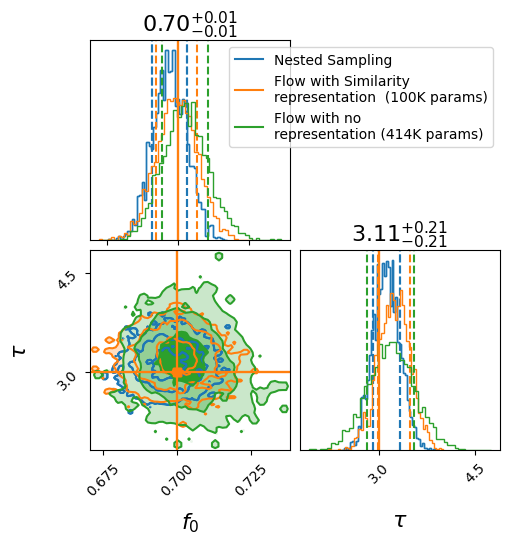

In [42]:
fig = bilby.result.plot_multiple(
    [bilby_result, flow_sim_result, flow_result],
    labels=['Nested Sampling',
            'Flow with Similarity \nrepresentation  (100K params)',
            'Flow with no \nrepresentation (414K params)'],
    truth=injection_parameters,
    corner_labels=[r"$f_0$", r"$\tau$"],
    quantiles=(0.16, 0.84),
    titles=True, save=True,
    filename='sg-comparison-bilby-with-sim.pdf'
)